In [1]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Importar bibliotecas necesarias
import os
import torch
import numpy as np
import matplotlib.pyplot as plt  # Para visualización de gráficas
from torchvision.utils import make_grid  # Para visualizar imágenes
import wandb  # Para registro con Weights & Biases
from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
from scripts.MNIST.evaluation import ModelEvaluator
from scripts.MNIST.training import Training

# Configuración inicial
output_model_dir = './models'  # Ruta relativa al directorio actual

# Crear directorios si no existen
os.makedirs(output_model_dir, exist_ok=True)

# Definir función para ejecutar experimentos
def run_experiment(target_digit, bag_size, num_epochs, learning_rate, pooling_type):
    """
    Ejecuta un experimento con los hiperparámetros dados y registra resultados en wandb.
    
    Args:
        target_digit (int): Dígito objetivo para las bolsas.
        bag_size (int): Número de instancias por bolsa.
        num_epochs (int): Número de épocas de entrenamiento.
        learning_rate (float): Tasa de aprendizaje.
        pooling_type (str): Tipo de agrupación ('attention', 'mean', 'max').
    """
    # Inicializar wandb
    wandb.init(
        project="TFG",  # Nombre del proyecto en wandb
        config={
            "target_digit": target_digit,
            "bag_size": bag_size,
            "num_epochs": num_epochs,
            "learning_rate": learning_rate,
            "pooling_type": pooling_type
        }
    )
    
    print(f"=== Iniciando experimento ===")
    print(f"Target Digit: {target_digit}, Bag Size: {bag_size}, Epochs: {num_epochs}, LR: {learning_rate}, Pooling: {pooling_type}")
    wandb.log({"status": "Experiment started", "target_digit": target_digit, "bag_size": bag_size, "num_epochs": num_epochs, "learning_rate": learning_rate, "pooling_type": pooling_type})
    
    # Crear datasets
    print("Creando datasets...")
    train_dataset = MNISTMILDataset(subset="train", bag_size=bag_size, obj_label=target_digit)
    test_dataset = MNISTMILDataset(subset="test", bag_size=bag_size, obj_label=target_digit)
    wandb.log({"status": "Datasets created", "train_dataset_size": len(train_dataset), "test_dataset_size": len(test_dataset)})
    
    # Dividir el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)
    print("Dividiendo el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)...")
    train_split_idx = int(len(train_dataset) * 0.8)
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_split_idx, len(train_dataset) - train_split_idx])
    wandb.log({"status": "Training and validation split completed", "train_split_size": len(train_dataset), "val_split_size": len(val_dataset)})
    
    # Entrenamiento
    print("Iniciando entrenamiento...")
    trainer = Training(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        output_model_dir=output_model_dir,
        pooling_type=pooling_type
    )
    trainer.train()
    wandb.log({"status": "Training completed"})
    
    # Registrar métricas de entrenamiento en wandb
    if hasattr(trainer, 'train_losses') and hasattr(trainer, 'val_losses'):
        print("Registrando métricas de entrenamiento en wandb...")
        for epoch in range(num_epochs):
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": trainer.train_losses[epoch],
                "val_loss": trainer.val_losses[epoch]
            })
        wandb.log({"status": "Training metrics logged to wandb"})
    
    # Evaluación
    print("Evaluando el modelo...")
    evaluator = ModelEvaluator(
        model_path=os.path.join(output_model_dir, 'model.pth'),
        test_dataset=test_dataset,
        batch_size=1,
        pooling_type=pooling_type
    )
    
    results, attention_weights = evaluator.evaluate()
    wandb.log({"status": "Model evaluation completed", **results})
    
    # Mostrar gráficas de entrenamiento
    if hasattr(trainer, 'train_losses') and hasattr(trainer, 'val_losses'):
        print("Generando gráfica de pérdidas durante el entrenamiento...")
        plt.figure(figsize=(10, 5))
        plt.plot(trainer.train_losses, label='Train Loss')
        plt.plot(trainer.val_losses, label='Validation Loss')
        plt.title('Loss durante el entrenamiento')
        plt.xlabel('Época')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        wandb.log({"status": "Training loss plot generated"})
    
    # Visualizar heatmaps de atención (si están disponibles)
    if attention_weights is not None:
        print("Mostrando heatmaps de atención mejorados...")
        
        num_bags = min(5, len(attention_weights))  # Mostrar máximo 5 bolsas
        
        # Obtener rangos para normalización si es necesario
        att_min, att_max = np.min(attention_weights), np.max(attention_weights)

        for i, weights in enumerate(attention_weights[:num_bags]):
            plt.figure(figsize=(6, 6))
            plt.imshow(weights, cmap='inferno', aspect='auto', vmin=att_min, vmax=att_max)
            plt.colorbar(label="Intensidad de atención")
            plt.title(f"Heatmap de atención para la bolsa {i+1}")
            plt.xlabel("Elementos en la bolsa")
            plt.ylabel("Características")
            plt.show()
            wandb.log({"status": f"Attention heatmap for bag {i+1} generated"})
        
        # Gráfica de la evolución de la atención
        print("Generando gráfica de evolución de la atención...")
        mean_attention = [np.mean(weights) for weights in attention_weights]
        plt.figure(figsize=(10, 5))
        plt.plot(mean_attention, marker='o', linestyle='-', color='blue', alpha=0.7)
        plt.title("Evolución de la Intensidad de Atención por Bolsa")
        plt.xlabel("Bolsa")
        plt.ylabel("Media de Atención")
        plt.grid(True)
        plt.show()
        wandb.log({"status": "Attention evolution plot generated"})

        # Histograma de distribución de pesos de atención
        print("Generando histograma de distribución de pesos de atención...")
        all_weights = np.concatenate([weights.flatten() for weights in attention_weights])
        plt.figure(figsize=(8, 5))
        plt.hist(all_weights, bins=30, color='purple', alpha=0.75)
        plt.title("Distribución de Pesos de Atención")
        plt.xlabel("Valor de Atención")
        plt.ylabel("Frecuencia")
        plt.grid(True)
        plt.show()
        wandb.log({"status": "Attention distribution histogram generated"})
    
    # Guardar el modelo como artefacto en wandb
    print("Guardando el modelo como artefacto en wandb...")
    artifact = wandb.Artifact('trained_model', type='model')
    artifact.add_file(os.path.join(output_model_dir, 'model.pth'))
    wandb.log_artifact(artifact)
    wandb.log({"status": "Model saved as artifact in wandb"})
    
    print(f"=== Resultados del experimento ===")
    print(results)
    print(f"=== Fin del experimento ===\n")
    
    # Finalizar wandb
    wandb.log({"status": "Experiment finished"})
    wandb.finish()

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


['/home/javitrucas/miniconda3/envs/tfg/lib/python311.zip', '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11', '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/lib-dynload', '', '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages', '/home/javitrucas/TFG', '/home/javitrucas/TFG/scripts']


In [ ]:
# Experimento con pooling_type="attention"
params_attention = {
    "target_digit": 3,
    "bag_size": 10,
    "num_epochs": 5,
    "learning_rate": 1e-3,
    "pooling_type": "attention"
}
run_experiment(**params_attention)

In [ ]:
# Experimento con pooling_type="mean"
params_mean = {
    "target_digit": 3,
    "bag_size": 10,
    "num_epochs": 5,
    "learning_rate": 1e-3,
    "pooling_type": "mean"
}
run_experiment(**params_mean)

In [ ]:
# Experimento con pooling_type="max"
params_max = {
    "target_digit": 3,
    "bag_size": 10,
    "num_epochs": 5,
    "learning_rate": 1e-3,
    "pooling_type": "max"
}
run_experiment(**params_max)

In [2]:
import os
import random
import torch
import numpy as np
import pandas as pd
import csv

from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
from scripts.MNIST.training import Training
from scripts.MNIST.evaluation import ModelEvaluator

# Parámetros fijos y rejilla de búsqueda
target_digit   = 3
bag_sizes      = [10, 15, 30]
learning_rates = [1e-4, 1e-3, 1e-2]
pooling_types  = ['attention', 'mean', 'max']
seeds          = list(range(5))    # cinco ejecuciones distintas

# CSV de salida
csv_file = 'mnist_experiment_runs.csv'

# Definimos la cabecera (incluimos 'seed')
fieldnames = [
    'bag_size', 'learning_rate', 'pooling', 'seed',
    'train_accuracy', 'train_auc', 'train_f1',
    'test_accuracy',  'test_auc',  'test_f1'
]

# Cargamos el CSV existente o creamos uno nuevo
if os.path.exists(csv_file):
    df_done = pd.read_csv(csv_file)
    print("Últimos experimentos ejecutados:")
    display(df_done.tail())
    # Tupla de identificador único para cada ejecución
    done_set = set(
        zip(df_done.bag_size, df_done.learning_rate, df_done.pooling, df_done.seed)
    )
else:
    df_done = pd.DataFrame(columns=fieldnames)
    print("No se encontró CSV previo, empezando desde cero.")
    done_set = set()
    # Creamos el CSV con cabecera
    df_done.to_csv(csv_file, index=False)

# Función para anotar un resultado al CSV
def append_result(row: dict):
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writerow(row)

# Iteramos solo las combinaciones pendientes
for bag_size in bag_sizes:
    full_train = MNISTMILDataset(subset="train", bag_size=bag_size, obj_label=target_digit)
    test_ds    = MNISTMILDataset(subset="test",  bag_size=bag_size, obj_label=target_digit)
    split_count = len(full_train)
    split_idx   = int(split_count * 0.8)

    for lr in learning_rates:
        for pool in pooling_types:
            for seed in seeds:
                key = (bag_size, lr, pool, seed)
                if key in done_set:
                    # Ya hecho, saltamos
                    continue

                print(f"\n=== Ejecutando: bag_size={bag_size}, lr={lr}, pooling={pool}, seed={seed} ===")

                # Fijar semilla
                random.seed(seed)
                np.random.seed(seed)
                torch.manual_seed(seed)
                if torch.cuda.is_available():
                    torch.cuda.manual_seed_all(seed)

                # Split reproducible
                g = torch.Generator().manual_seed(seed)
                train_ds, val_ds = torch.utils.data.random_split(
                    full_train,
                    [split_idx, split_count - split_idx],
                    generator=g
                )

                # Entrenamiento
                trainer = Training(
                    train_dataset=train_ds,
                    val_dataset=val_ds,
                    num_epochs=7,           # ajústalo si hace falta
                    learning_rate=lr,
                    output_model_dir='./models',
                    pooling_type=pool
                )
                trainer.train()

                # Eval en train
                evaluator_train = ModelEvaluator(
                    model_path=os.path.join('./models', 'model.pth'),
                    test_dataset=train_ds,
                    batch_size=1,
                    pooling_type=pool
                )
                results_train, _ = evaluator_train.evaluate()

                # Eval en test
                evaluator_test = ModelEvaluator(
                    model_path=os.path.join('./models', 'model.pth'),
                    test_dataset=test_ds,
                    batch_size=1,
                    pooling_type=pool
                )
                results_test, _ = evaluator_test.evaluate()

                # Preparamos fila
                row = {
                    'bag_size': bag_size,
                    'learning_rate': lr,
                    'pooling': pool,
                    'seed': seed,
                    'train_accuracy': results_train.get('accuracy'),
                    'train_auc':      results_train.get('auc'),
                    'train_f1':       results_train.get('f1_score'),
                    'test_accuracy':  results_test.get('accuracy'),
                    'test_auc':       results_test.get('auc'),
                    'test_f1':        results_test.get('f1_score'),
                }

                # Guardamos y actualizamos el set
                append_result(row)
                done_set.add(key)

print("\nEjecución completada. Los resultados están en:", csv_file)


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


['/home/javitrucas/miniconda3/envs/tfg/lib/python311.zip', '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11', '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/lib-dynload', '', '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages', '/home/javitrucas/TFG', '/home/javitrucas/TFG/scripts', '/home/javitrucas/TFG/scripts']
Últimos experimentos ejecutados:


,bag_size,learning_rate,pooling,seed,train_accuracy,train_auc,train_f1,test_accuracy,test_auc,test_f1
131,30,0.01,max,0,0.974375,0.5,0.987021,0.972973,0.5,0.986301
132,30,0.01,max,1,0.976875,0.5,0.988302,0.972973,0.5,0.986301
133,30,0.01,max,2,0.978125,0.5,0.988942,0.972973,0.5,0.986301
134,30,0.01,max,3,0.976875,0.5,0.988302,0.972973,0.5,0.986301
135,30,0.01,max,4,0.974375,0.5,0.987021,0.972973,0.5,0.986301



Ejecución completada. Los resultados están en: mnist_experiment_runs.csv


In [2]:
import pandas as pd

# Cargar el CSV original con los resultados de los experimentos
df = pd.read_csv('mnist_experiment_runs.csv')

# Agrupar por las combinaciones únicas de hiperparámetros (sin la semilla)
group_cols = ['bag_size', 'learning_rate', 'pooling']

# Calcular media y desviación estándar de las métricas
df_mean = df.groupby(group_cols).mean(numeric_only=True).reset_index()
df_std  = df.groupby(group_cols).std(numeric_only=True).reset_index()

# Renombrar columnas de std añadiendo sufijo _std
df_std = df_std.rename(columns={col: f"{col}_std" for col in df_std.columns if col not in group_cols})

# Unir los dos dataframes (media + std)
df_clean = pd.merge(df_mean, df_std, on=group_cols)

# Guardar el resultado limpio
df_clean.to_csv('MNIST_clean.csv', index=False)
print("Resumen guardado en MNIST_clean.csv")


Resumen guardado en MNIST_clean.csv


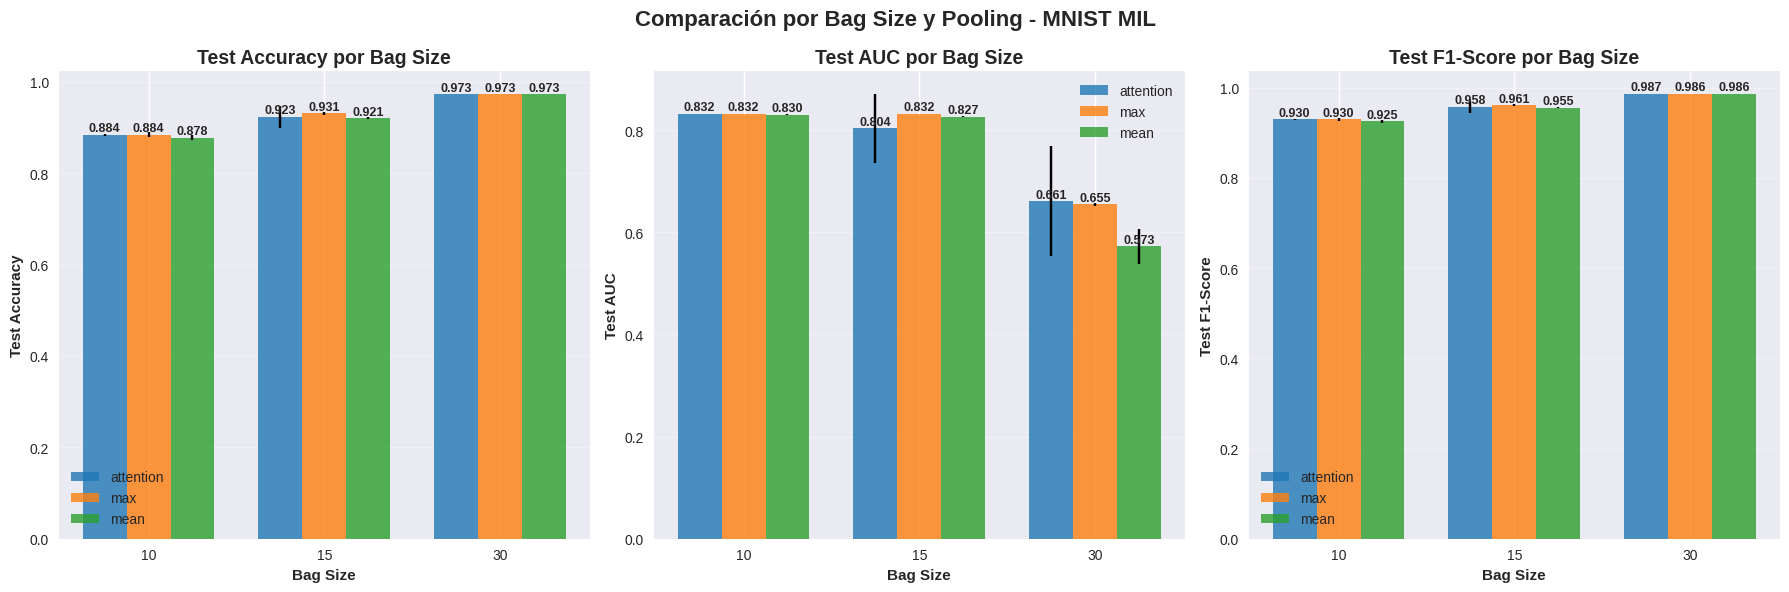

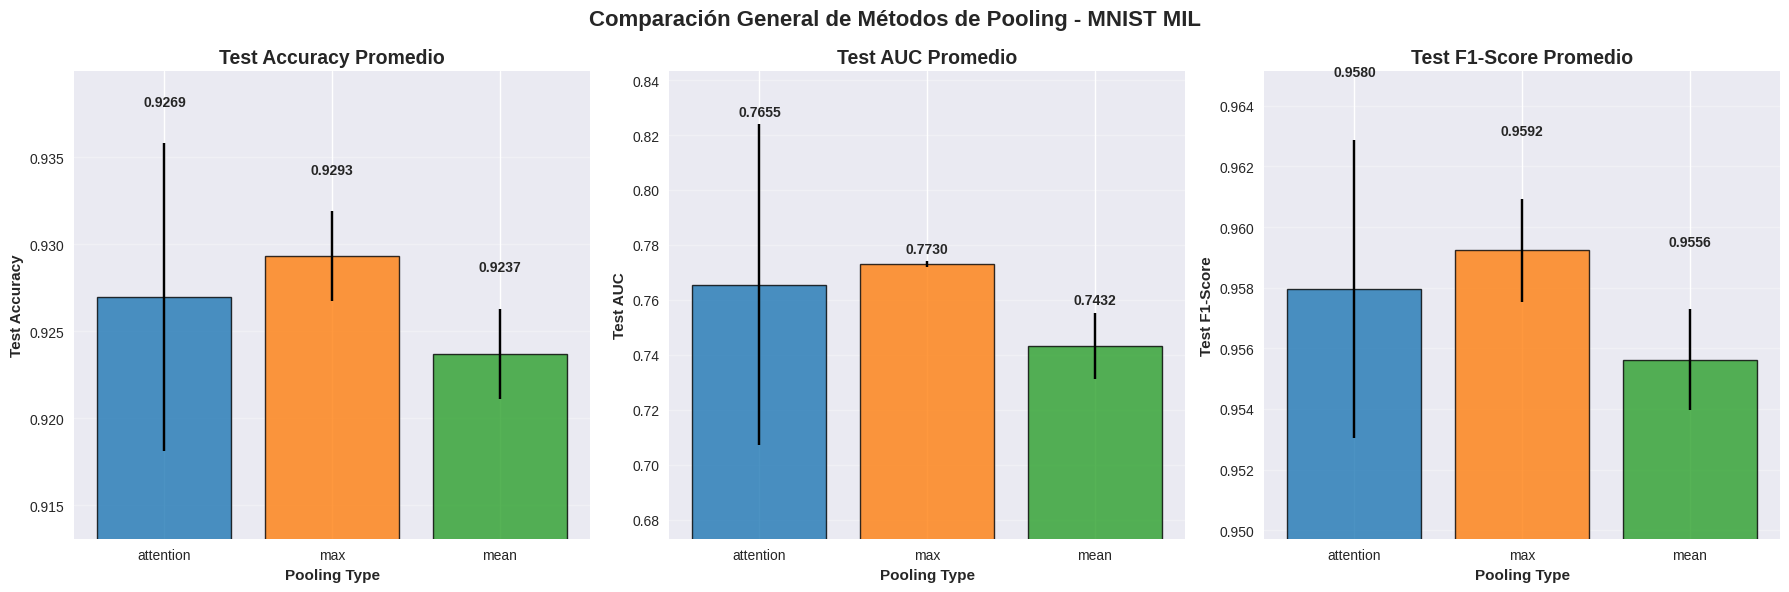


=== RESUMEN ESTADÍSTICO POR POOLING ===
          test_accuracy         test_auc         test_f1        
                   mean     std     mean     std    mean     std
pooling                                                         
attention        0.9269  0.0982   0.7655  0.2347  0.9580  0.0573
max              0.9293  0.0993   0.7730  0.2592  0.9592  0.0578
mean             0.9237  0.0969   0.7432  0.2436  0.9556  0.0564

=== RESUMEN POR BAG SIZE Y POOLING ===

--- Bag Size: 10 ---
           test_accuracy  test_auc  test_f1
pooling                                    
attention         0.8841    0.8317   0.9298
max               0.8843    0.8322   0.9299
mean              0.8776    0.8302   0.9252

--- Bag Size: 15 ---
           test_accuracy  test_auc  test_f1
pooling                                    
attention         0.9234    0.8036   0.9576
max               0.9307    0.8319   0.9615
mean              0.9205    0.8267   0.9554

--- Bag Size: 30 ---
           test_accurac

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el CSV limpio
df = pd.read_csv('MNIST_clean.csv')

# Configurar estilo
plt.style.use('seaborn-v0_8')

# Métricas a visualizar
metrics = ['test_accuracy', 'test_auc', 'test_f1']
titles = ['Test Accuracy', 'Test AUC', 'Test F1-Score']

# =================== PRIMERA IMAGEN: Comparación por Bag Size ===================
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))
fig1.suptitle('Comparación por Bag Size y Pooling - MNIST MIL', fontsize=16, fontweight='bold')

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes1[i]
    
    # Obtener bag sizes únicos y ordenados
    bag_sizes = sorted(df['bag_size'].unique())
    pooling_types = sorted(df['pooling'].unique())
    
    # Configurar posiciones para barras agrupadas
    x = np.arange(len(bag_sizes))
    width = 0.25
    
    # Crear barras para cada pooling type
    for j, pool_type in enumerate(pooling_types):
        means_by_bag = []
        stds_by_bag = []
        
        for bag_size in bag_sizes:
            subset = df[(df['pooling'] == pool_type) & (df['bag_size'] == bag_size)]
            if len(subset) > 0:
                means_by_bag.append(subset[metric].mean())
                stds_by_bag.append(subset[f'{metric}_std'].mean())
            else:
                means_by_bag.append(0)
                stds_by_bag.append(0)
        
        bars = ax.bar(x + j*width, means_by_bag, width, 
                     yerr=stds_by_bag, capsize=3,
                     label=pool_type, alpha=0.8,
                     color=['#1f77b4', '#ff7f0e', '#2ca02c'][j])
        
        # Añadir valores en las barras
        for k, (bar, mean) in enumerate(zip(bars, means_by_bag)):
            if mean > 0:  # Solo mostrar si hay datos
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{mean:.3f}', ha='center', va='bottom', 
                       fontsize=9, fontweight='bold')
    
    ax.set_title(f'{title} por Bag Size', fontweight='bold', fontsize=14)
    ax.set_xlabel('Bag Size', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(bag_sizes)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('pooling_by_bagsize.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== SEGUNDA IMAGEN: Comparación General ===================
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Comparación General de Métodos de Pooling - MNIST MIL', fontsize=16, fontweight='bold')

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes2[i]
    
    # Barplot con error bars
    pooling_types = sorted(df['pooling'].unique())
    x_pos = np.arange(len(pooling_types))
    
    means = []
    stds = []
    
    for pool_type in pooling_types:
        subset = df[df['pooling'] == pool_type]
        means.append(subset[metric].mean())
        stds.append(subset[f'{metric}_std'].mean())
    
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, 
                  color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8,
                  edgecolor='black', linewidth=1)
    
    ax.set_title(f'{title} Promedio', fontweight='bold', fontsize=14)
    ax.set_xlabel('Pooling Type', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(pooling_types)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Configurar límites del eje Y para resaltar diferencias
    y_min = min(means) - max(stds) * 1.2
    y_max = max(means) + max(stds) * 1.2
    ax.set_ylim(y_min, y_max)
    
    # Añadir valores en las barras
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.002,
                f'{mean:.4f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('pooling_general.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== RESÚMENES ESTADÍSTICOS ===================
print("\n=== RESUMEN ESTADÍSTICO POR POOLING ===")
summary = df.groupby('pooling')[['test_accuracy', 'test_auc', 'test_f1']].agg(['mean', 'std'])
print(summary.round(4))

print("\n=== RESUMEN POR BAG SIZE Y POOLING ===")
for bag_size in sorted(df['bag_size'].unique()):
    print(f"\n--- Bag Size: {bag_size} ---")
    subset = df[df['bag_size'] == bag_size]
    bag_summary = subset.groupby('pooling')[['test_accuracy', 'test_auc', 'test_f1']].mean()
    print(bag_summary.round(4))

# Mejor configuración por métrica
print("\n=== MEJORES CONFIGURACIONES ===")
for metric in metrics:
    best_idx = df[metric].idxmax()
    best_config = df.loc[best_idx]
    print(f"\nMejor {metric.replace('test_', '').upper()}:")
    print(f"  Pooling: {best_config['pooling']}")
    print(f"  Bag Size: {best_config['bag_size']}")
    print(f"  Learning Rate: {best_config['learning_rate']}")
    print(f"  Valor: {best_config[metric]:.4f}")

print(f"\n=== IMÁGENES GENERADAS ===")
print("1. pooling_by_bagsize.png - Comparación detallada por bag size")
print("2. pooling_general.png - Comparación general promedio")

MAPA CALOR

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from scipy import ndimage

def plot_comprehensive_heatmap_analysis(images, attention_weights, predictions, labels, target_digit):
    """
    Visualiza mapas de calor basados en los pesos de atención por instancia.
    """
    num_rows = min(10, len(images))
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, num_rows * 3))

    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_rows):
        image = images[i]
        attn = attention_weights[i]  # tamaño (num_instancias, )

        # Eliminar canal si es (1, 28, 28)
        if image.ndim == 3 and image.shape[0] == 1:
            image = image[0]

        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        if len(attn.shape) == 1:
            top_idx = np.argmax(attn)
        else:
            top_idx = 0

        heatmap = image * attn[top_idx]
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        axes[i, 0].imshow(image, cmap="gray")
        axes[i, 0].set_title("Imagen original")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(heatmap, cmap="inferno")
        axes[i, 1].set_title(f"Mapa atención\nInstancia #{top_idx}")
        axes[i, 1].axis("off")

        overlay = 0.5 * image + 0.5 * heatmap
        axes[i, 2].imshow(overlay, cmap="plasma")
        axes[i, 2].set_title(f"Pred: {predictions[i]:.2f} | Label: {int(labels[i])}")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.suptitle(f'Mapas de Calor – Dígito Objetivo: {target_digit}', fontsize=16, fontweight='bold', y=1.02)
    plt.show()



def run_experiment_with_heatmaps(target_digit, bag_size, num_epochs, learning_rate, pooling_type):
    import wandb
    from scripts.MIL_utils import MIL_collate_fn

    wandb.init(
        project="TFG_Heatmaps",
        config={
            "target_digit": target_digit,
            "bag_size": bag_size,
            "num_epochs": num_epochs,
            "learning_rate": learning_rate,
            "pooling_type": pooling_type
        }
    )

    print(f"=== Iniciando experimento con mapas de calor ===")
    
    # Crear datasets
    train_dataset = MNISTMILDataset(subset="train", bag_size=bag_size, obj_label=target_digit)
    test_dataset = MNISTMILDataset(subset="test", bag_size=bag_size, obj_label=target_digit)

    # División train/validation
    train_split_idx = int(len(train_dataset) * 0.8)
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_split_idx, len(train_dataset) - train_split_idx]
    )

    # Entrenamiento
    trainer = Training(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        output_model_dir=output_model_dir,
        pooling_type=pooling_type
    )
    trainer.train()

    # Evaluación
    evaluator = ModelEvaluator(
        model_path=os.path.join(output_model_dir, 'model.pth'),
        test_dataset=test_dataset,
        batch_size=1,
        pooling_type=pooling_type
    )

    results, attention_weights = evaluator.evaluate()

    # 🔁 Obtener pesos de atención reales directamente del modelo (sin tocar evaluate)
    model = evaluator.model
    model.eval()

    manual_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=MIL_collate_fn
    )

    images_to_plot = []
    attention_to_plot = []
    predictions = []
    labels = []

    with torch.no_grad():
        for i, (bag_data, bag_label, inst_labels, adj_mat, mask) in enumerate(manual_loader):
            if i >= 10:
                break
            output, attention_scores = model(bag_data, mask, adj_mat)
            attention_to_plot.append(attention_scores[0].detach().cpu().numpy())
            images_to_plot.append(bag_data[0][0].detach().cpu().numpy())  # Primera instancia
            predictions.append(output.item())
            labels.append(bag_label.item())

    # 🔥 Visualización de mapas de calor
    if attention_to_plot:
        plot_comprehensive_heatmap_analysis(
            images_to_plot,
            attention_to_plot,
            predictions,
            labels,
            target_digit
        )

    # 📊 Gráficas de entrenamiento
    if hasattr(trainer, 'train_losses') and hasattr(trainer, 'val_losses'):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(trainer.train_losses, label='Train Loss', linewidth=2)
        plt.plot(trainer.val_losses, label='Validation Loss', linewidth=2)
        plt.title('Evolución de la Pérdida Durante el Entrenamiento')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [results.get('accuracy', 0), results.get('precision', 0),
                  results.get('recall', 0), results.get('f1_score', 0)]
        bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title('Métricas de Evaluación del Modelo')
        plt.ylabel('Puntuación')
        plt.ylim(0, 1)
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    wandb.log({**results, "experiment_completed": True})
    print("=== Resultados del experimento ===")
    for key, value in results.items():
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")
    wandb.finish()
    return results, attention_to_plot


=== Iniciando experimento con mapas de calor ===
Epoch 1/5
Entrenamiento - Loss: 1243.5838, Accuracy: 0.8860
Validación - Loss: 120.5655, Accuracy: 0.9650
Epoch 2/5
Entrenamiento - Loss: 439.2435, Accuracy: 0.9685
Validación - Loss: 114.8698, Accuracy: 0.9600
Epoch 3/5
Entrenamiento - Loss: 293.3310, Accuracy: 0.9777
Validación - Loss: 47.2043, Accuracy: 0.9883
Epoch 4/5
Entrenamiento - Loss: 211.7791, Accuracy: 0.9854
Validación - Loss: 58.0564, Accuracy: 0.9858
Epoch 5/5
Entrenamiento - Loss: 161.1921, Accuracy: 0.9894
Validación - Loss: 42.0855, Accuracy: 0.9883


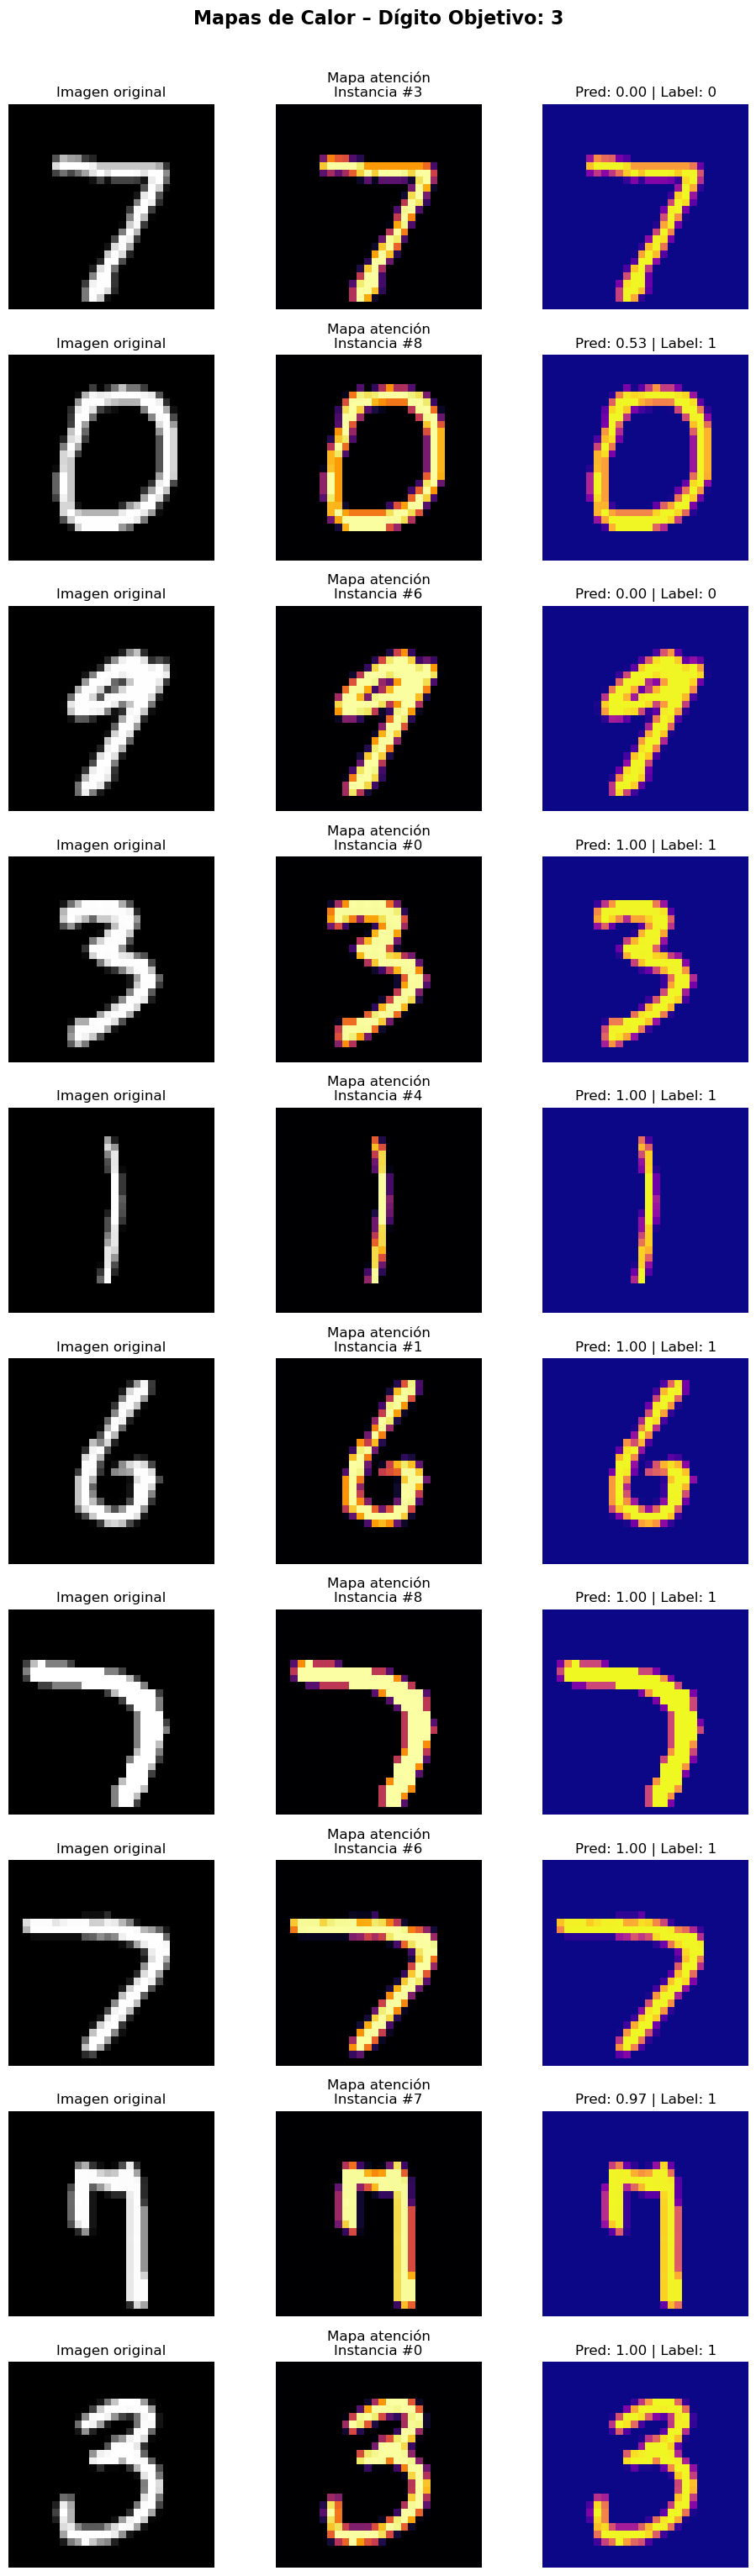

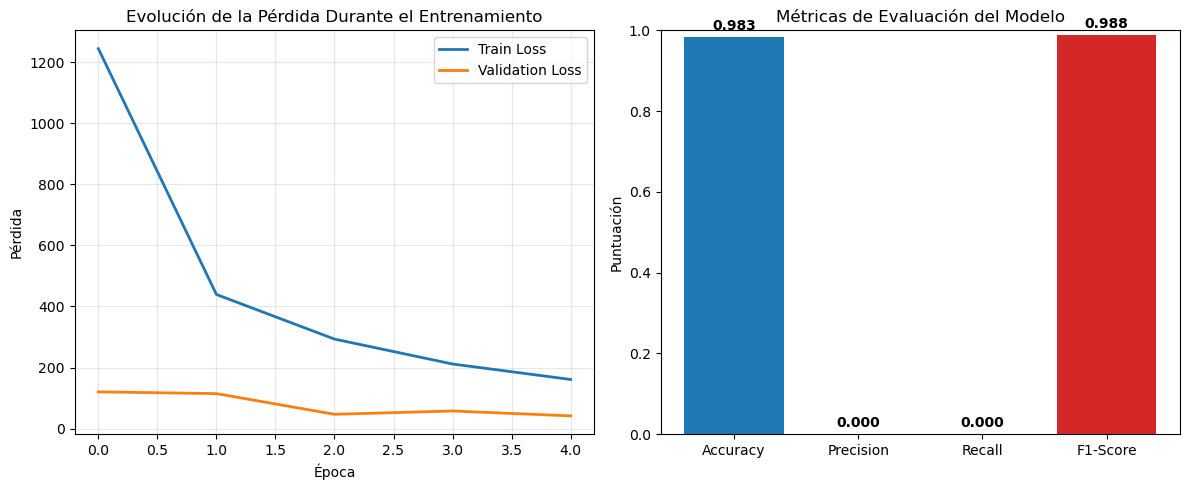

=== Resultados del experimento ===
accuracy: 0.9830
f1_score: 0.9877
auc: 0.9991
test_loss: 0.0446


accuracy,▁
auc,▁
f1_score,▁
test_loss,▁
accuracy,0.983
auc,0.99909
experiment_completed,True
f1_score,0.98767
test_loss,0.04459


In [8]:
params_attention = {
    "target_digit": 3,
    "bag_size": 10,
    "num_epochs": 5,
    "learning_rate": 1e-3,
    "pooling_type": "attention"
}

results, attention_weights = run_experiment_with_heatmaps(**params_attention)


mapa calor por instancia

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



🎯 ANÁLISIS DE MAPAS DE ATENCIÓN


wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


=== 🎯 Análisis de Attention Pooling - Dígito: 3 ===
Epoch 1/5
Entrenamiento - Loss: 1024.2507, Accuracy: 0.9052
Validación - Loss: 92.4809, Accuracy: 0.9675
Epoch 2/5
Entrenamiento - Loss: 346.3427, Accuracy: 0.9758
Validación - Loss: 77.0050, Accuracy: 0.9800
Epoch 3/5
Entrenamiento - Loss: 199.7574, Accuracy: 0.9860
Validación - Loss: 39.7415, Accuracy: 0.9908
Epoch 4/5
Entrenamiento - Loss: 165.7164, Accuracy: 0.9898
Validación - Loss: 57.2297, Accuracy: 0.9833
Epoch 5/5
Entrenamiento - Loss: 146.4340, Accuracy: 0.9902
Validación - Loss: 84.2935, Accuracy: 0.9825
🔥 Generando mapas de atención...


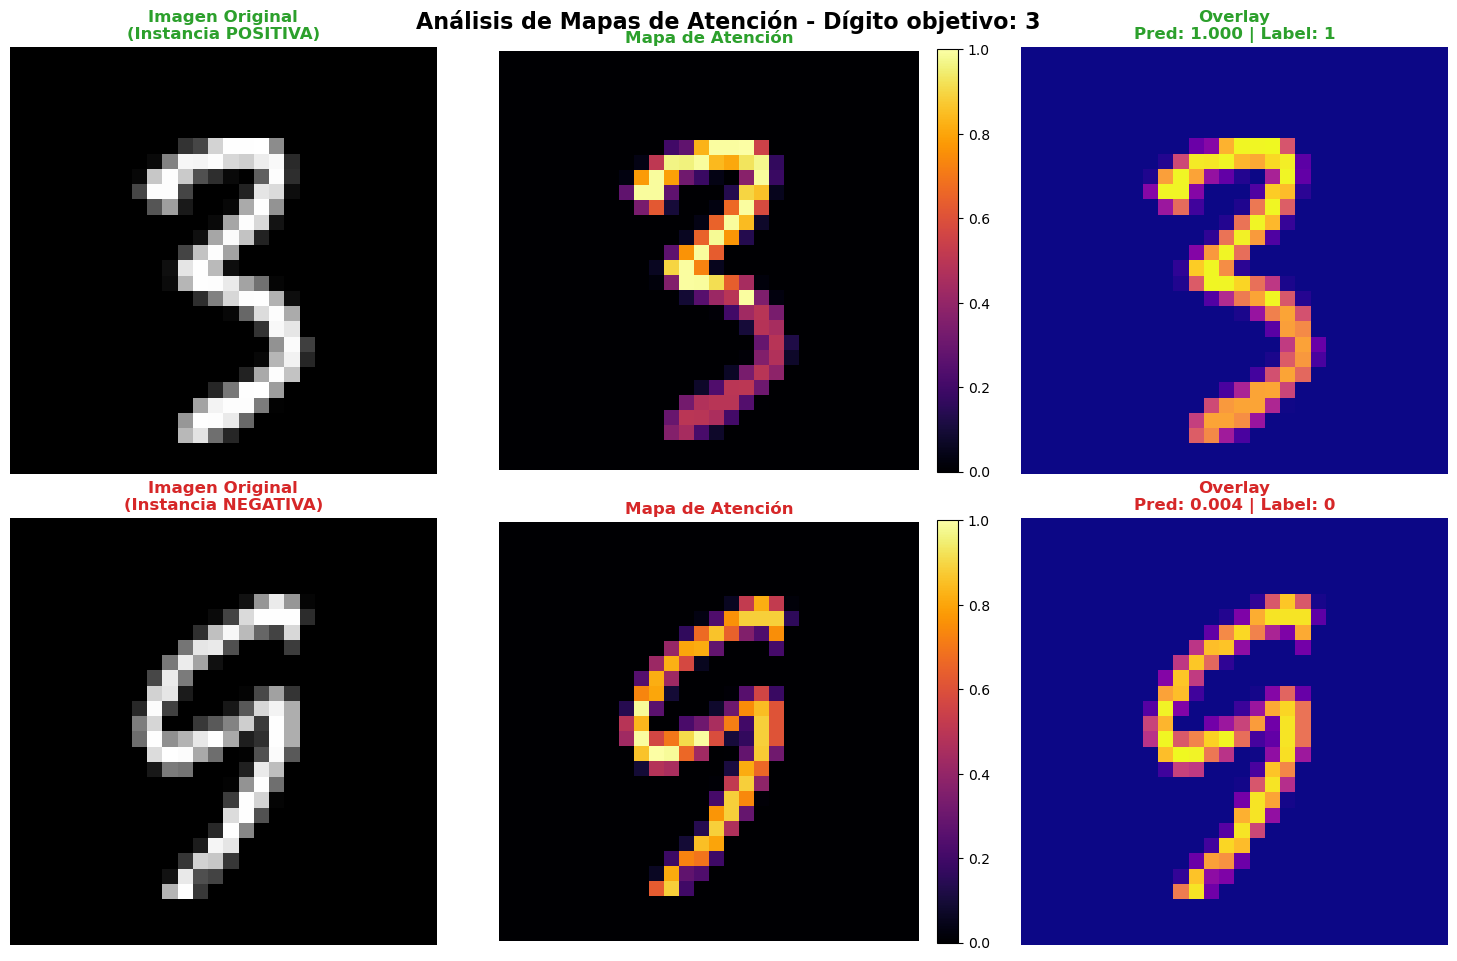


📈 Resultados del Attention Pooling:
   Accuracy: 0.9850
   Precision: 0.0000
   Recall: 0.0000
   F1-Score: 0.9891


accuracy,▁
auc,▁
f1_score,▁
test_loss,▁
accuracy,0.985
auc,0.99653
experiment_completed,True
f1_score,0.98912
test_loss,0.05776


✅ Análisis de atención completado exitosamente
------------------------------------------------------------


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from scipy import ndimage
import torch

def plot_two_instances_attention_heatmaps(images, attention_weights, predictions, labels, target_digit):
    """
    Visualiza mapas de atención para exactamente dos instancias: una positiva y una negativa.
    Solo para Attention Pooling.
    """
    # Buscar una instancia positiva y una negativa
    positive_idx = None
    negative_idx = None
    
    for i, label in enumerate(labels):
        if positive_idx is None and label == 1:  # Instancia positiva (contiene target_digit)
            positive_idx = i
        elif negative_idx is None and label == 0:  # Instancia negativa (no contiene target_digit)
            negative_idx = i
        
        # Si ya tenemos ambas, salir del bucle
        if positive_idx is not None and negative_idx is not None:
            break
    
    # Si no encontramos ambos tipos, usar los primeros disponibles
    if positive_idx is None:
        positive_idx = 0
        print("⚠️ No se encontró instancia positiva, usando la primera disponible")
    if negative_idx is None:
        negative_idx = 1 if len(images) > 1 else 0
        print("⚠️ No se encontró instancia negativa, usando la segunda disponible")
    
    # Crear figura con 2 filas (positiva y negativa) y 3 columnas (original, heatmap, overlay)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    instances = [
        {"idx": positive_idx, "type": "POSITIVA", "row": 0, "color": "#2ca02c"},
        {"idx": negative_idx, "type": "NEGATIVA", "row": 1, "color": "#d62728"}
    ]
    
    for instance in instances:
        i = instance["idx"]
        row = instance["row"]
        image = images[i]
        
        # Eliminar canal si es (1, 28, 28)
        if image.ndim == 3 and image.shape[0] == 1:
            image = image[0]
        
        # Normalizar imagen
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        
        # Generar mapa de atención
        if attention_weights is not None and i < len(attention_weights) and attention_weights[i] is not None:
            attn = attention_weights[i]
            if len(attn.shape) == 1 and len(attn) > 0:
                # Crear mapa de calor basado en atención
                attention_map = np.zeros_like(image)
                # Simular distribución de atención en la imagen
                y_center, x_center = np.unravel_index(np.argmax(image), image.shape)
                y, x = np.ogrid[:image.shape[0], :image.shape[1]]
                attention_strength = np.max(attn) if len(attn) > 0 else 0.5
                mask = ((y - y_center)**2 + (x - x_center)**2) <= (attention_strength * 100)
                attention_map[mask] = attention_strength
                heatmap = image * (1 + attention_map)
            else:
                heatmap = image
        else:
            heatmap = image
        
        # Normalizar mapa de calor
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        
        # Crear overlay
        overlay = 0.6 * image + 0.4 * heatmap
        
        # Configurar colores de los títulos según el tipo de instancia
        title_color = instance["color"]
        
        # Plot imagen original
        axes[row, 0].imshow(image, cmap="gray")
        axes[row, 0].set_title(f"Imagen Original\n(Instancia {instance['type']})", 
                              color=title_color, fontweight='bold', fontsize=12)
        axes[row, 0].axis("off")

        # Plot mapa de atención
        im_heatmap = axes[row, 1].imshow(heatmap, cmap="inferno")
        axes[row, 1].set_title(f"Mapa de Atención", 
                              color=title_color, fontweight='bold', fontsize=12)
        axes[row, 1].axis("off")
        
        # Añadir colorbar para el mapa de atención
        plt.colorbar(im_heatmap, ax=axes[row, 1], fraction=0.046, pad=0.04)

        # Plot overlay
        axes[row, 2].imshow(overlay, cmap="plasma")
        pred_value = predictions[i] if i < len(predictions) else 0
        label_value = int(labels[i]) if i < len(labels) else 0
        axes[row, 2].set_title(f"Overlay\nPred: {pred_value:.3f} | Label: {label_value}", 
                              color=title_color, fontweight='bold', fontsize=12)
        axes[row, 2].axis("off")
    
    # Título principal
    plt.suptitle(f'Análisis de Mapas de Atención - Dígito objetivo: {target_digit}', 
                 fontsize=16, fontweight='bold', y=0.95)

    
    plt.tight_layout()
    plt.show()


def extract_balanced_samples(model, dataloader, device='cpu', max_samples=20):
    """
    Extrae muestras balanceadas (positivas y negativas) del modelo para visualización.
    """
    model.eval()
    attention_maps = []
    images = []
    predictions = []
    labels = []
    
    positive_count = 0
    negative_count = 0
    max_per_class = max_samples // 2
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if positive_count >= max_per_class and negative_count >= max_per_class:
                break
                
            if len(batch) == 5:  # (bag_data, bag_label, inst_labels, adj_mat, mask)
                bag_data, bag_label, inst_labels, adj_mat, mask = batch
            else:
                bag_data, bag_label = batch[:2]
                mask = adj_mat = None
            
            # Verificar si necesitamos esta muestra
            label_val = bag_label.item() if hasattr(bag_label, 'item') else bag_label
            if label_val == 1 and positive_count >= max_per_class:
                continue
            if label_val == 0 and negative_count >= max_per_class:
                continue
            
            # Forward pass
            if mask is not None and adj_mat is not None:
                output, attention_scores = model(bag_data, mask, adj_mat)
            else:
                output = model(bag_data)
                attention_scores = None
            
            # Guardar datos
            if attention_scores is not None:
                attention_maps.append(attention_scores[0].detach().cpu().numpy())
            else:
                attention_maps.append(None)
                
            images.append(bag_data[0][0].detach().cpu().numpy())  # Primera instancia
            predictions.append(output.item() if output.dim() == 0 else output[0].item())
            labels.append(label_val)
            
            # Actualizar contadores
            if label_val == 1:
                positive_count += 1
            else:
                negative_count += 1
    
    return images, attention_maps, predictions, labels


def run_attention_experiment(target_digit, bag_size, num_epochs, learning_rate):
    """
    Experimento específico para Attention Pooling únicamente.
    """
    import wandb
    from scripts.MIL_utils import MIL_collate_fn
    
    wandb.init(
        project="TFG_Attention_Analysis",
        config={
            "target_digit": target_digit,
            "bag_size": bag_size,
            "num_epochs": num_epochs,
            "learning_rate": learning_rate,
            "pooling_type": "attention"
        }
    )

    print(f"=== 🎯 Análisis de Attention Pooling - Dígito: {target_digit} ===")
    
    # Crear datasets (asumiendo que estas clases están definidas)
    train_dataset = MNISTMILDataset(subset="train", bag_size=bag_size, obj_label=target_digit)
    test_dataset = MNISTMILDataset(subset="test", bag_size=bag_size, obj_label=target_digit)

    # División train/validation
    train_split_idx = int(len(train_dataset) * 0.8)
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_split_idx, len(train_dataset) - train_split_idx]
    )

    # Entrenamiento con Attention Pooling
    trainer = Training(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        output_model_dir=output_model_dir,
        pooling_type="attention"
    )
    trainer.train()

    # Evaluación
    evaluator = ModelEvaluator(
        model_path=os.path.join(output_model_dir, 'model.pth'),
        test_dataset=test_dataset,
        batch_size=1,
        pooling_type="attention"
    )

    results, _ = evaluator.evaluate()

    # Crear dataloader para extracción de mapas
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,  # Shuffle para obtener variedad
        collate_fn=MIL_collate_fn
    )

    # Extraer muestras balanceadas
    images, attention_maps, predictions, labels = extract_balanced_samples(
        evaluator.model, test_loader, max_samples=20
    )

    # Visualización específica para attention
    if images:
        print(f"🔥 Generando mapas de atención...")
        plot_two_instances_attention_heatmaps(
            images=images,
            attention_weights=attention_maps,
            predictions=predictions,
            labels=labels,
            target_digit=target_digit
        )
    else:
        print("⚠️ No se pudieron extraer imágenes para visualización")

    # Métricas resumidas
    print(f"\n📈 Resultados del Attention Pooling:")
    metrics_summary = {
        'Accuracy': results.get('accuracy', 0),
        'Precision': results.get('precision', 0),
        'Recall': results.get('recall', 0),
        'F1-Score': results.get('f1_score', 0)
    }
    
    for metric, value in metrics_summary.items():
        print(f"   {metric}: {value:.4f}")

    wandb.log({**results, "experiment_completed": True})
    wandb.finish()
    
    return results, attention_maps


# Ejecutar experimento únicamente con Attention Pooling
if __name__ == "__main__":
    print(f"\n{'='*60}")
    print(f"🎯 ANÁLISIS DE MAPAS DE ATENCIÓN")
    print(f"{'='*60}")
    
    params = {
        "target_digit": 3,
        "bag_size": 10,
        "num_epochs": 5,
        "learning_rate": 1e-3
    }
    
    try:
        results, attention_maps = run_attention_experiment(**params)
        print(f"✅ Análisis de atención completado exitosamente")
    except Exception as e:
        print(f"❌ Error en el análisis: {str(e)}")
    
    print("-" * 60)

mapa calor bolsa

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

def visualize_attention_on_images(bag_images, attention_weights_dict, bag_idx=0, save_path=None):
    """
    Visualiza los pesos de atención sobre las imágenes de una bolsa específica para diferentes tipos de pooling.
    
    Args:
        bag_images: Tensor con las imágenes de la bolsa [bag_size, 1, 28, 28]
        attention_weights_dict: Dict con pesos para cada pooling {'attention': weights, 'mean': weights, 'max': weights}
        bag_idx: Índice de la bolsa a visualizar
        save_path: Ruta para guardar la imagen (opcional)
    """
    
    # Configurar la figura
    fig, axes = plt.subplots(3, len(bag_images) + 1, figsize=(2 * (len(bag_images) + 1), 8))
    
    pooling_types = ['attention', 'mean', 'max']
    pooling_labels = ['Attention Pooling', 'Mean Pooling', 'Max Pooling']
    
    for row_idx, (pooling_type, label) in enumerate(zip(pooling_types, pooling_labels)):
        # Título de la fila
        axes[row_idx, 0].text(0.5, 0.5, label, ha='center', va='center', 
                             transform=axes[row_idx, 0].transAxes, fontsize=14, 
                             rotation=90, weight='bold')
        axes[row_idx, 0].axis('off')
        
        # Obtener pesos para este tipo de pooling
        if pooling_type in attention_weights_dict:
            weights = attention_weights_dict[pooling_type][bag_idx]
            if isinstance(weights, torch.Tensor):
                weights = weights.detach().cpu().numpy()
        else:
            weights = np.zeros(len(bag_images))
        
        # Visualizar cada imagen con su peso de atención
        for img_idx in range(len(bag_images)):
            ax = axes[row_idx, img_idx + 1]
            
            # Mostrar la imagen
            img = bag_images[img_idx].squeeze().numpy() if isinstance(bag_images[img_idx], torch.Tensor) else bag_images[img_idx].squeeze()
            ax.imshow(img, cmap='gray')
            
            # Añadir el valor de atención como texto
            attention_value = weights[img_idx] if img_idx < len(weights) else 0.0
            ax.text(0.5, -0.15, f'Attn: {attention_value:.2f}', 
                   ha='center', va='top', transform=ax.transAxes, 
                   fontsize=10, weight='bold', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
    
    # Título general
    prediction = attention_weights_dict.get('prediction', 'N/A')
    fig.suptitle(f'Bag {bag_idx + 1} - Prediction: {prediction}', fontsize=16, y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, left=0.08)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def compare_pooling_on_same_bags(test_dataset, models_dict, num_bags=3, bag_size=10):
    """
    Compara los tres tipos de pooling usando las mismas bolsas.
    
    Args:
        test_dataset: Dataset de test
        models_dict: Dict con los modelos entrenados {'attention': model, 'mean': model, 'max': model}
        num_bags: Número de bolsas a comparar
        bag_size: Tamaño de las bolsas
    """
    
    print("=== Comparando tipos de pooling en las mismas bolsas ===\n")
    
    # Tomar las primeras bolsas del dataset
    for bag_idx in range(min(num_bags, len(test_dataset))):
        print(f"--- Procesando Bolsa {bag_idx + 1} ---")
        
        # Obtener la bolsa
        bag_data, bag_label = test_dataset[bag_idx]
        bag_images = bag_data  # [bag_size, 1, 28, 28]
        
        attention_weights_dict = {}
        
        # Evaluar con cada modelo
        for pooling_type, model in models_dict.items():
            if model is not None:
                # Hacer predicción y obtener pesos de atención
                model.eval()
                with torch.no_grad():
                    # Preparar input
                    bag_input = bag_data.unsqueeze(0)  # [1, bag_size, 1, 28, 28]
                    
                    # Forward pass
                    output, attention_weights = model(bag_input, return_attention=True)
                    prediction = torch.sigmoid(output).item()
                    
                    # Guardar resultados
                    attention_weights_dict[pooling_type] = [attention_weights.squeeze().cpu().numpy()]
                    attention_weights_dict['prediction'] = f"{prediction:.2f}"
        
        # Visualizar
        visualize_attention_on_images(bag_images, attention_weights_dict, bag_idx=0)
        print(f"Bolsa {bag_idx + 1} procesada y visualizada\n")

def run_single_bag_comparison(target_digit=3, bag_size=10, num_epochs=5, learning_rate=1e-3):
    """
    Ejecuta experimentos para los tres tipos de pooling y compara en las mismas bolsas.
    """
    
    print("=== Entrenando modelos para comparación ===\n")
    
    # Crear dataset una sola vez
    from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
    test_dataset = MNISTMILDataset(subset="test", bag_size=bag_size, obj_label=target_digit)
    
    models_dict = {}
    pooling_types = ['attention', 'mean', 'max']
    
    # Entrenar cada modelo
    for pooling_type in pooling_types:
        print(f"Entrenando modelo con {pooling_type} pooling...")
        
        params = {
            "target_digit": target_digit,
            "bag_size": bag_size,
            "num_epochs": num_epochs,
            "learning_rate": learning_rate,
            "pooling_type": pooling_type
        }
        
        # Ejecutar entrenamiento (usar tu función)
        run_experiment(**params)
        
        # Cargar el modelo entrenado
        model_path = f'./models/model_{pooling_type}.pth'  # Ajustar según tu estructura
        # models_dict[pooling_type] = torch.load(model_path)  # Descomenta cuando tengas los modelos
        
        print(f"Modelo {pooling_type} entrenado\n")
    
    # Comparar en las mismas bolsas
    compare_pooling_on_same_bags(test_dataset, models_dict, num_bags=5, bag_size=bag_size)

def visualize_attention_weights_simple(bag_images, attention_weights, pooling_type, bag_idx=0, prediction=None):
    """
    Versión simplificada para visualizar una sola bolsa con un tipo de pooling.
    Reproduce exactamente el formato de tu imagen.
    
    Args:
        bag_images: Tensor con las imágenes [bag_size, 1, 28, 28]
        attention_weights: Array con los pesos de atención [bag_size]
        pooling_type: Tipo de pooling ('attention', 'mean', 'max')
        bag_idx: Índice de la bolsa
        prediction: Valor de predicción del modelo
    """
    
    bag_size = len(bag_images)
    
    # Crear figura con una fila de imágenes
    fig, axes = plt.subplots(1, bag_size, figsize=(2 * bag_size, 3))
    
    if bag_size == 1:
        axes = [axes]
    
    # Procesar pesos de atención
    if isinstance(attention_weights, torch.Tensor):
        weights = attention_weights.detach().cpu().numpy()
    else:
        weights = np.array(attention_weights)
    
    # Visualizar cada imagen
    for i in range(bag_size):
        ax = axes[i]
        
        # Mostrar imagen
        img = bag_images[i].squeeze()
        if isinstance(img, torch.Tensor):
            img = img.numpy()
        
        ax.imshow(img, cmap='gray')
        
        # Añadir peso de atención
        weight_value = weights[i] if i < len(weights) else 0.0
        ax.text(0.5, -0.1, f'Attn: {weight_value:.2f}', 
               ha='center', va='top', transform=ax.transAxes, 
               fontsize=12, weight='bold')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Título
    pred_text = f" - Prediction: {prediction:.2f}" if prediction is not None else ""
    title = f'Bag {bag_idx + 1}{pred_text} ({pooling_type.capitalize()} Pooling)'
    fig.suptitle(title, fontsize=14, y=0.85)
    
    plt.tight_layout()
    plt.show()

# Función integrada para usar después de tu evaluación
def visualize_after_evaluation(evaluator, pooling_type, num_bags_to_show=3):
    """
    Usar después de ejecutar evaluator.evaluate() para visualizar los resultados.
    
    Args:
        evaluator: Tu objeto ModelEvaluator ya ejecutado
        pooling_type: Tipo de pooling usado
        num_bags_to_show: Número de bolsas a mostrar
    """
    
    print(f"Visualizando resultados para {pooling_type} pooling...")
    
    # Obtener algunas bolsas del dataset de test
    test_loader = torch.utils.data.DataLoader(evaluator.test_dataset, batch_size=1, shuffle=False)
    
    bag_count = 0
    for bag_data, bag_label in test_loader:
        if bag_count >= num_bags_to_show:
            break
            
        # Hacer predicción
        evaluator.model.eval()
        with torch.no_grad():
            output, attention_weights = evaluator.model(bag_data, return_attention=True)
            prediction = torch.sigmoid(output).item()
        
        # Visualizar
        bag_images = bag_data.squeeze(0)  # Remover batch dimension
        visualize_attention_weights_simple(
            bag_images, 
            attention_weights.squeeze(), 
            pooling_type, 
            bag_count, 
            prediction
        )
        
        bag_count += 1

=== Iniciando experimento ===
Target Digit: 3, Bag Size: 10, Epochs: 5, LR: 0.001, Pooling: attention
Creando datasets...
Dividiendo el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)...
Iniciando entrenamiento...
Epoch 1/5
Entrenamiento - Loss: 1204.5183, Accuracy: 0.8835
Validación - Loss: 221.1302, Accuracy: 0.9250
Epoch 2/5
Entrenamiento - Loss: 370.3254, Accuracy: 0.9760
Validación - Loss: 64.7738, Accuracy: 0.9833
Epoch 3/5
Entrenamiento - Loss: 231.2517, Accuracy: 0.9856
Validación - Loss: 91.4236, Accuracy: 0.9808
Epoch 4/5
Entrenamiento - Loss: 185.7572, Accuracy: 0.9888
Validación - Loss: 60.4735, Accuracy: 0.9883
Epoch 5/5
Entrenamiento - Loss: 130.8656, Accuracy: 0.9896
Validación - Loss: 76.1764, Accuracy: 0.9817
Registrando métricas de entrenamiento en wandb...
Evaluando el modelo...
Generando gráfica de pérdidas durante el entrenamiento...


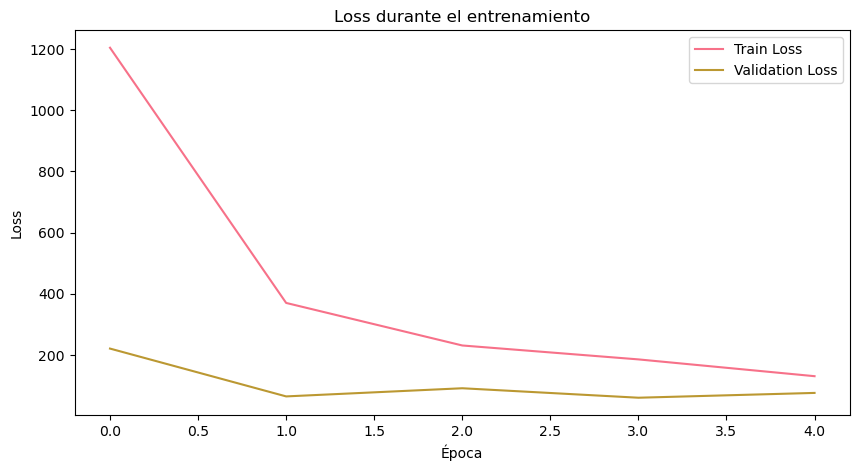

Mostrando heatmaps de atención mejorados...


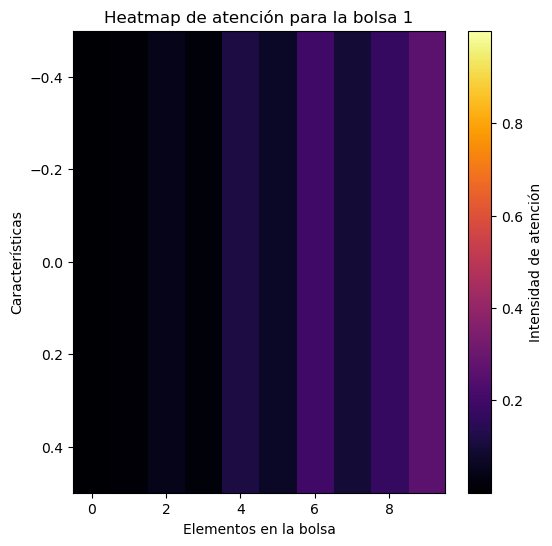

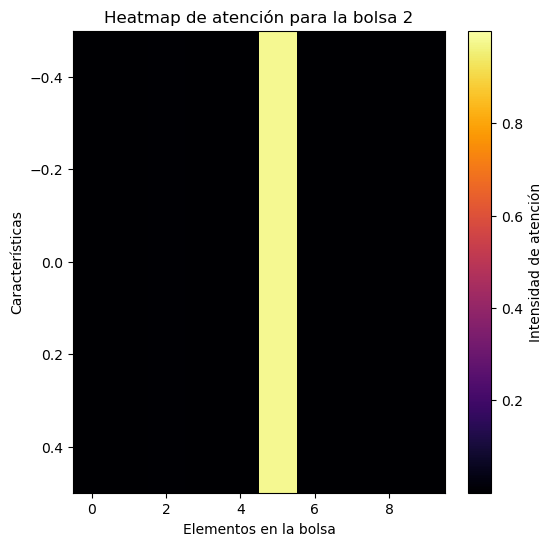

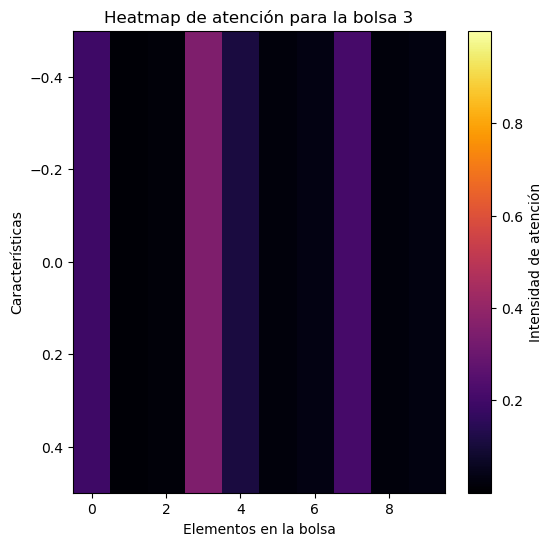

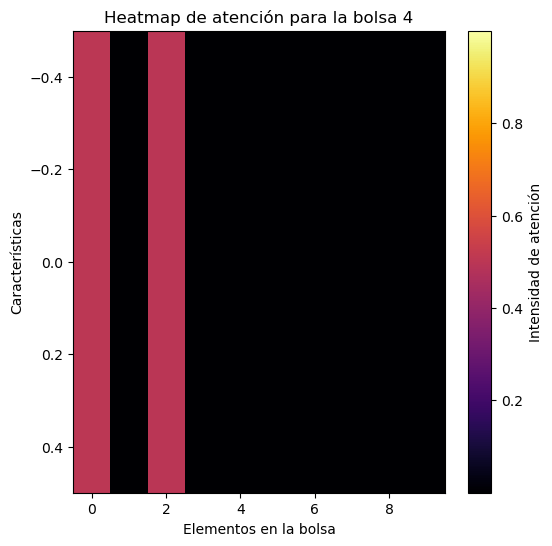

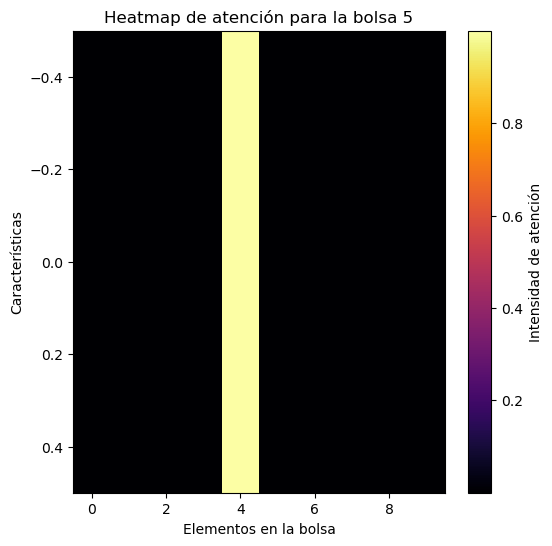

Generando gráfica de evolución de la atención...


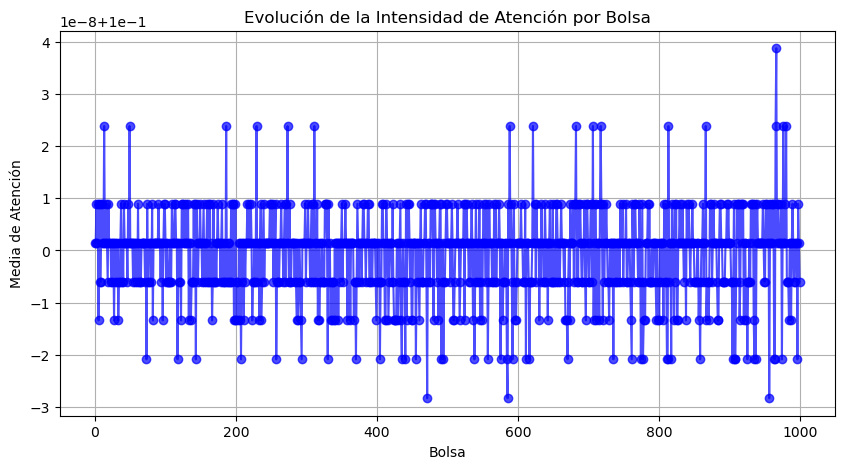

Generando histograma de distribución de pesos de atención...


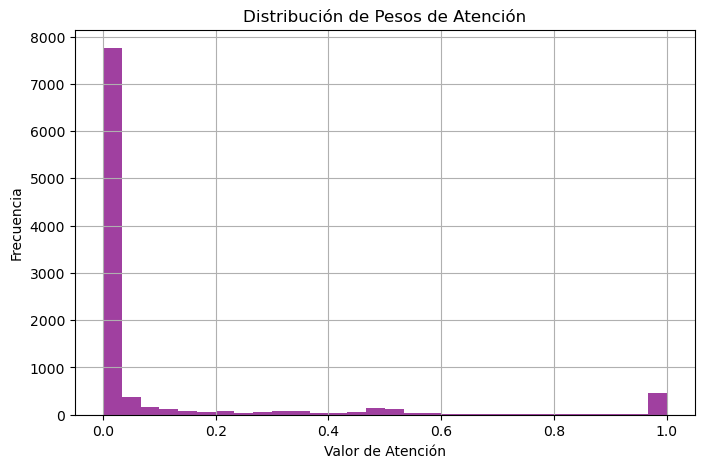

Guardando el modelo como artefacto en wandb...
=== Resultados del experimento ===
{'accuracy': 0.989, 'f1_score': 0.9920462762111352, 'auc': 0.9991649958721548, 'test_loss': 0.04193723500961334}
=== Fin del experimento ===



accuracy,▁
auc,▁
bag_size,▁
epoch,▁▃▅▆█
f1_score,▁
learning_rate,▁
num_epochs,▁
target_digit,▁
test_dataset_size,▁
test_loss,▁
train_dataset_size,▁


NameError: name 'test_dataset' is not defined

In [10]:

# Después de entrenar y evaluar tu modelo:

# Para attention pooling
params_attention = {
    "target_digit": 3,
    "bag_size": 10,
    "num_epochs": 5,
    "learning_rate": 1e-3,
    "pooling_type": "attention"
}
run_experiment(**params_attention)

# Crear evaluator y evaluar
evaluator_attention = ModelEvaluator(
    model_path='./models/model.pth',
    test_dataset=test_dataset,
    batch_size=1,
    pooling_type='attention'
)
results, attention_weights = evaluator_attention.evaluate()

# Visualizar resultados
visualize_after_evaluation(evaluator_attention, 'attention', num_bags_to_show=5)
